In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting u

In [ ]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [ ]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn' #pretrained bart model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)#loads the tokenizer associated with bart.
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [ ]:
samsum = load_dataset('samsum')
samsum

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

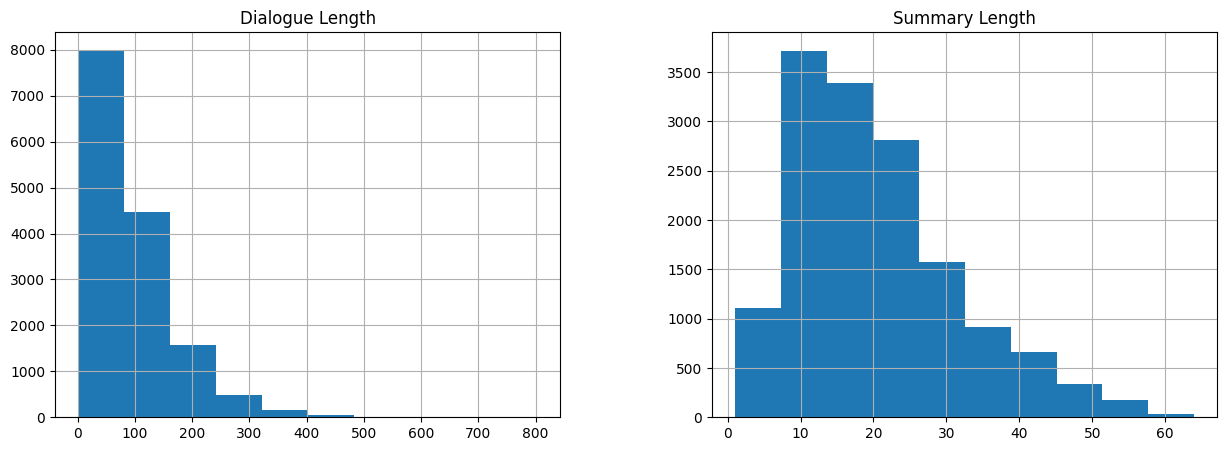

In [ ]:
#visualize the data
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [ ]:
#Feature encoding function.

def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
#Applying feature function to dataset
samsum_pt = samsum.map(get_feature, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
#pytorch format setting
columns = ['input_ids', 'labels', 'attention_mask']#indicates which tokens are padding and which tokens are actual inputs
samsum_pt.set_format(type='torch', columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)#prepares batches of data for the model

In [ ]:
#defines training arguments
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)
#creates a trainer object.

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#excecutes the training process
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=230, training_loss=1.4834195883377739, metrics={'train_runtime': 1810.7305, 'train_samples_per_second': 8.136, 'train_steps_per_second': 0.127, 'total_flos': 8823027777404928.0, 'train_loss': 1.4834195883377739, 'epoch': 0.9991854466467553})

In [ ]:
#saves the model
trainer.save_model('bart_samsum_model')

In [ ]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_samsum_model')#summarisation pipeline to predict using thetrained bart model.
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 70}

custom_dialogue="""
# Dialogue between Sita and Latha

Sita: "Latha, have you noticed how much we’ve changed over the years?"
Latha: "Definitely! It feels like just yesterday we were daydreaming about our future."

Sita: "Right? I used to think everything would be so simple. Now, it feels so complicated."
Latha: "Life has a way of throwing challenges our way. But I think those challenges help us grow."

Sita: "True. I appreciate the lessons, but sometimes I just wish things were easier."
Latha: "We all do! But remember, those tough moments make the good ones even sweeter."

Sita: "That’s a good perspective. I’ve been feeling overwhelmed lately with work and personal life."
Latha: "I understand. It’s important to take breaks and recharge. Have you thought about taking a little time for yourself?"

Sita: "I should. Maybe a weekend getaway could help."
Latha: "That sounds perfect! Nature has a way of soothing the soul."

Sita: "You’re right! Let’s plan something together. It’ll be fun!"
Latha: "Absolutely! A little adventure is just what we need."

"""`device`
print(pipe(custom_dialogue, **gen_kwargs))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'summary_text': 'Sita and Latha have changed a lot over the years. Sita has been feeling overwhelmed lately with work and personal life. She wants to take a weekend getaway with Latha to relax. Latha and Sita will go on an adventure together.'}]
